In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
df = pd.read_csv('training.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Unnamed: 0,id,name,type,w,h,dataset,diagnosis,diagnosis_confirm_type,age,sex
0,0,5aaf12491165976913627e89,ISIC_0024306,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,45,male
1,1,5aaf12491165976913627e95,ISIC_0024307,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,50,male
2,2,5aaf12491165976913627ea0,ISIC_0024308,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,55,female
3,3,5aaf12491165976913627eab,ISIC_0024309,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,40,male
4,4,5aaf12491165976913627eb6,ISIC_0024310,dermoscopic,600,450,HAM10000,melanoma,histopathology,60,male


In [3]:
X = df['name']
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

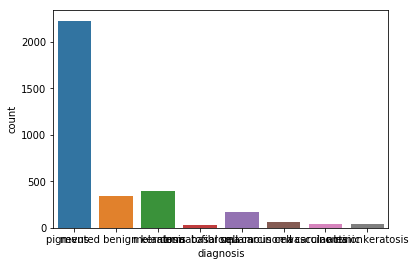

In [4]:
sns.countplot(y_test)

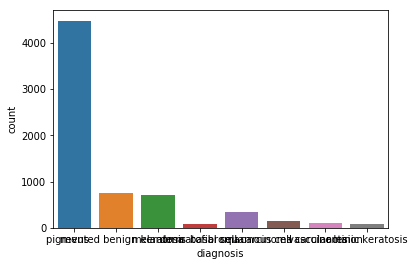

In [5]:
sns.countplot(y_train)

In [6]:
folder_names = list(y_train.unique())
folder_names

['nevus',
 'pigmented benign keratosis',
 'melanoma',
 'dermatofibroma',
 'basal cell carcinoma',
 'squamous cell carcinoma',
 'vascular lesion',
 'actinic keratosis']

In [7]:
import os
for fn in folder_names:
    os.mkdir('train/' + fn)
    os.mkdir('test/' + fn)

In [11]:
X_train_list = list(X_train)
y_train_list = list(y_train)
for i in range(len(X_train_list)):
    old_path = 'img/' + X_train_list[i] + ".jpg"
    new_path = 'train' + '/' + y_train_list[i] + '/' + X_train_list[i] + ".jpg"
    os.replace(old_path, new_path)

In [12]:
X_test_list = list(X_test)
y_test_list = list(y_test)
for i in range(len(X_test_list)):
    old_path = 'img/' + X_test_list[i] + ".jpg"
    new_path = 'test/' + y_test_list[i] + '/' + X_test_list[i] + ".jpg"
    os.replace(old_path, new_path)